#### Hand Sign Recognition -> It is a MultiClass Classification hence we will be using the MLP as our model architecture

# Imports

In [1]:
from numpy.random import seed
seed(888)
from tensorflow.random import set_seed
set_seed(404)

In [2]:
import os
import numpy as np
import cv2

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

# Constants

In [4]:
train_dir_alphabets = './Sign-Language-Alphabets-Dataset/asl_alphabet_train/asl_alphabet_train/'
test_dir_alphabets = './Sign-Language-Alphabets-Dataset/asl_alphabet_train/asl_alphabet_train/'
train_dir_digits = './Sign-Language-Digits-Dataset/Dataset/'
test_dir_digits = './Sign-Language-Digits-Dataset/Examples/'

map_idx_to_char = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
                  6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                  12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                  18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                  24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space',
                  29: 'other'}

map_char_to_idx = {v: k for k, v in map_idx_to_char.items()}

classes_alphabet = list(map_idx_to_char.values())

classes_digits = ['0','1','2','3','4','5','6','7','8','9']

IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE=1000
VALIDATION_RATIO = 0.1
NR_CLASSES = len(classes_alphabet) - 1
LOGGING_PATH = 'tensorboard_hand-sign_alphabets_logs/'

# A Look At The Data

## The Alphabets

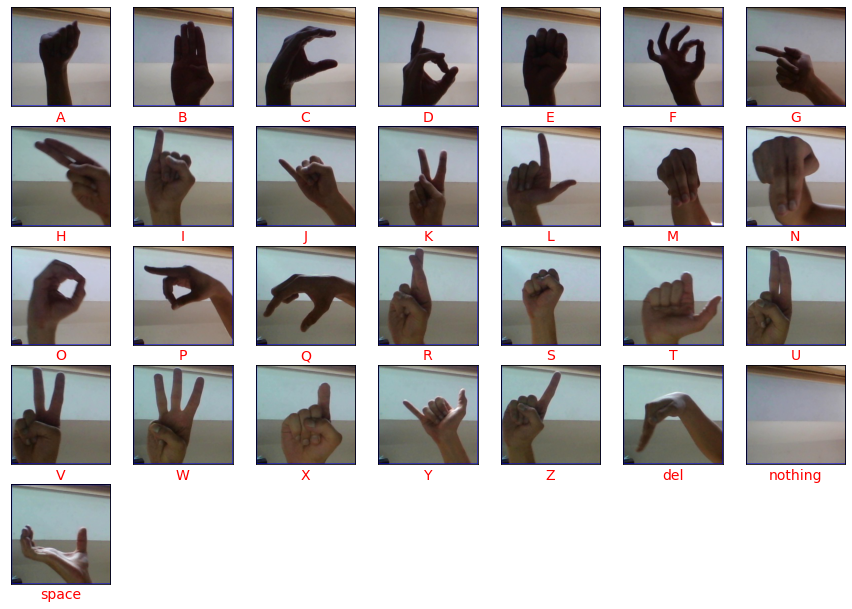

In [5]:
plt.figure(figsize=(15, 15))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir_alphabets + "/{0}/{0}1.jpg".format(classes_alphabet[i])
    img = plt.imread(path)
    plt.imshow(img)
    label = plt.xlabel(classes_alphabet[i], fontsize=14)
    label.set_color("red")


In [6]:
path = train_dir_alphabets + "/{0}/{0}1.jpg".format(classes_alphabet[0])
img = plt.imread(path)
x, y, c = img.shape
print(f'width = {x} \t| height = {y} \t| channels = {c}')

width = 200 	| height = 200 	| channels = 3


## The Digits

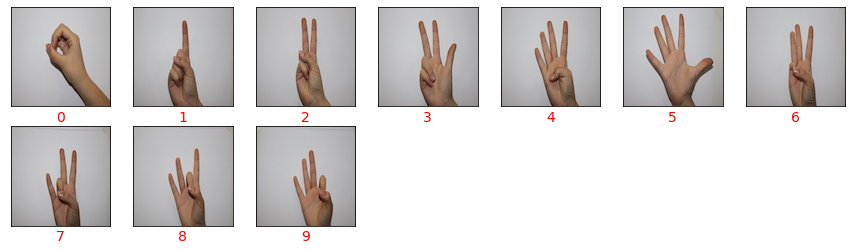

In [7]:
plt.figure(figsize=(15, 15))
for i in range (0,10):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = train_dir_digits + "{0}/".format(classes_digits[i])
    data = os.listdir(path)
    path = path + data[0]
    img = plt.imread(path)
    plt.imshow(img)
    label = plt.xlabel(classes_digits[i], fontsize=14)
    label.set_color("red")


#### From the above data it is clear that we cannot have a single model for digits and alphabets as it will create bias due to different number of data points and some alphabets are too similar to some digits

# Continuing For Alphabets

# Get The Data

In [5]:
def load_data(train_dir_alphabets):
    images = []
    labels = []
    size = IMAGE_HEIGHT,IMAGE_WIDTH
    for directory in os.listdir(train_dir_alphabets):
        for image in os.listdir(train_dir_alphabets + "/" + directory):
            img = cv2.imread(train_dir_alphabets + '/' + directory + '/' + image)
            final_img = cv2.resize(img, size)
            images.append(final_img)
            idx = map_char_to_idx.get(directory)
            labels.append(idx)
        print('loaded:', directory, 'label:', idx)
    images = np.array(images)
    labels = utils.to_categorical(labels)
    
    return images,labels

In [6]:
%%time

images,labels = load_data(train_dir_alphabets)
nr_images, x, y, c = images.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

loaded: A label: 0
loaded: B label: 1
loaded: C label: 2
loaded: D label: 3
loaded: del label: 26
loaded: E label: 4
loaded: F label: 5
loaded: G label: 6
loaded: H label: 7
loaded: I label: 8
loaded: J label: 9
loaded: K label: 10
loaded: L label: 11
loaded: M label: 12
loaded: N label: 13
loaded: nothing label: 27
loaded: O label: 14
loaded: P label: 15
loaded: Q label: 16
loaded: R label: 17
loaded: S label: 18
loaded: space label: 28
loaded: T label: 19
loaded: U label: 20
loaded: V label: 21
loaded: W label: 22
loaded: X label: 23
loaded: Y label: 24
loaded: Z label: 25
images = 87000 	| width = 64 	| height = 64 	| channels = 3
Wall time: 3min 21s


# Exlpore The Data

In [7]:
nr_images, x, y, c = images.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 87000 	| width = 64 	| height = 64 	| channels = 3


# Data Preprocessing 

In [8]:
images = images.astype('float32')/255.0

In [9]:
images[0][0][0]

array([0.8784314 , 0.00392157, 0.03137255], dtype=float32)

In [10]:
images.shape

(87000, 64, 64, 3)

In [11]:
labels.shape

(87000, 29)

# Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)

In [13]:
X_train.shape

(78300, 64, 64, 3)

In [14]:
X_test.shape

(8700, 64, 64, 3)

In [15]:
y_test.shape

(8700, 29)

# Tensorflow Architecture Setup

#### Hyperparameters

In [16]:
nr_epochs = 50
learning_rate = 1e-3

#### Defining the model

### Model 1

In [20]:
mlp = Sequential()

mlp.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))

mlp.add(Conv2D(64 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))

mlp.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))

mlp.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp.add(MaxPooling2D(pool_size = (2, 2)))

mlp.add(Flatten())

mlp.add(Dense(units = 512, activation = 'relu'))
mlp.add(Dropout(0.25))

mlp.add(Dense(NR_CLASSES, activation='softmax'))

In [21]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

### Model 2

In [23]:
mlp2 = Sequential()

mlp2.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Conv2D(128 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))


mlp2.add(Conv2D(256 , (3,3), padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp2.add(MaxPooling2D(pool_size = (2, 2)))

mlp2.add(Flatten())

mlp2.add(Dropout(0.5))
mlp2.add(Dense(1024, activation='sigmoid'))
mlp2.add(Dense(NR_CLASSES, activation='softmax'))

In [24]:
mlp2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)        

### Model 3

In [37]:
mlp3 = Sequential()

mlp3.add(Conv2D(64, kernel_size = 5, padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp3.add(MaxPooling2D(pool_size = (2, 2)))

mlp3.add(Conv2D(64 , kernel_size = 5, padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp3.add(MaxPooling2D(pool_size = (2, 2)))
mlp3.add(Dropout(0.5))

mlp3.add(Conv2D(128 , kernel_size = 5, padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp3.add(MaxPooling2D(pool_size = (2, 2)))

mlp3.add(Conv2D(128 , kernel_size = 5, padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp3.add(MaxPooling2D(pool_size = (2, 2)))
mlp3.add(Dropout(0.5))


mlp3.add(Conv2D(256 , kernel_size = 5, padding = 'same', activation = 'relu',
               input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, COLOR_CHANNELS)))
mlp3.add(MaxPooling2D(pool_size = (2, 2)))

mlp3.add(Flatten())

mlp3.add(Dense(NR_CLASSES, activation='softmax'))

In [38]:
mlp3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 128)        

# Tensorboard Setup

In [19]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOGGING_PATH, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')
    return TensorBoard(log_dir=dir_paths, histogram_freq=1)

# Train the models

In [25]:
adam = Adam(lr=learning_rate)

In [28]:
mlp.compile(loss ='categorical_crossentropy', optimizer=adam ,metrics =['accuracy'])

In [26]:
mlp2.compile(loss ='categorical_crossentropy', optimizer=adam ,metrics =['accuracy'])

In [39]:
mlp3.compile(loss ='categorical_crossentropy', optimizer=adam ,metrics =['accuracy'])

### Train

In [31]:
history = mlp.fit(X_train, y_train, batch_size=64, epochs=nr_epochs, validation_split=VALIDATION_RATIO, shuffle = True, verbose=1,
                  callbacks=[get_tensorboard('Model 1 MLP-VAL')])

Successfully created directory
Epoch 1/50
1102/1102 [==============================] - 23s 15ms/step - loss: 3.2617 - accuracy: 0.0667 - val_loss: 2.7927 - val_accuracy: 0.1345
Epoch 2/50
1102/1102 [==============================] - 15s 14ms/step - loss: 2.6448 - accuracy: 0.1455 - val_loss: 2.2493 - val_accuracy: 0.1716
Epoch 3/50
1102/1102 [==============================] - 15s 14ms/step - loss: 2.1865 - accuracy: 0.1754 - val_loss: 2.0290 - val_accuracy: 0.1768
Epoch 4/50
1102/1102 [==============================] - 15s 14ms/step - loss: 2.0292 - accuracy: 0.1737 - val_loss: 1.9531 - val_accuracy: 0.1847
Epoch 5/50
1102/1102 [==============================] - 15s 13ms/step - loss: 1.9602 - accuracy: 0.1742 - val_loss: 1.9463 - val_accuracy: 0.1765
Epoch 6/50
1102/1102 [==============================] - 15s 13ms/step - loss: 1.9378 - accuracy: 0.1737 - val_loss: 1.9058 - val_accuracy: 0.1731
Epoch 7/50
1102/1102 [==============================] - 15s 14ms/step - loss: 1.9123 - accura

In [27]:
history2 = mlp2.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=VALIDATION_RATIO, shuffle = True, verbose=1,
                  callbacks=[get_tensorboard('Model 2 MLP-VAL')])

Successfully created directory
Epoch 1/10
1102/1102 [==============================] - 92s 82ms/step - loss: 2.1686 - accuracy: 0.3698 - val_loss: 0.0803 - val_accuracy: 0.9750
Epoch 2/10
1102/1102 [==============================] - 88s 80ms/step - loss: 0.0885 - accuracy: 0.9711 - val_loss: 0.0207 - val_accuracy: 0.9930
Epoch 3/10
1102/1102 [==============================] - 89s 80ms/step - loss: 0.0476 - accuracy: 0.9844 - val_loss: 0.0129 - val_accuracy: 0.9955
Epoch 4/10
1102/1102 [==============================] - 87s 79ms/step - loss: 0.0328 - accuracy: 0.9891 - val_loss: 0.0111 - val_accuracy: 0.9966
Epoch 5/10
1102/1102 [==============================] - 86s 78ms/step - loss: 0.0304 - accuracy: 0.9899 - val_loss: 0.0361 - val_accuracy: 0.9909
Epoch 6/10
1102/1102 [==============================] - 88s 80ms/step - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.0081 - val_accuracy: 0.9964
Epoch 7/10
1102/1102 [==============================] - 88s 80ms/step - loss: 0.0193 - accura

In [53]:
history3 = mlp3.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=VALIDATION_RATIO, shuffle = True, verbose=1,
                  callbacks=[get_tensorboard('Model 3 MLP-VAL')])

Successfully created directory
Epoch 1/5
1102/1102 [==============================] - 30s 27ms/step - loss: 3.3675 - accuracy: 0.0329 - val_loss: 3.3676 - val_accuracy: 0.0336
Epoch 2/5
1102/1102 [==============================] - 30s 27ms/step - loss: 3.3675 - accuracy: 0.0337 - val_loss: 3.3675 - val_accuracy: 0.0327
Epoch 3/5
1102/1102 [==============================] - 30s 27ms/step - loss: 3.3676 - accuracy: 0.0338 - val_loss: 3.3675 - val_accuracy: 0.0327
Epoch 4/5
1102/1102 [==============================] - 30s 27ms/step - loss: 3.3675 - accuracy: 0.0333 - val_loss: 3.3675 - val_accuracy: 0.0349
Epoch 5/5
1102/1102 [==============================] - 30s 27ms/step - loss: 3.3675 - accuracy: 0.0344 - val_loss: 3.3675 - val_accuracy: 0.0349


# Visualizing Accuracy

Text(0.5, 1.0, 'Accuracy evolution')

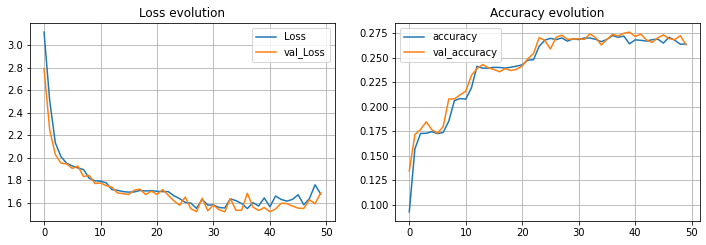

In [50]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

# Model 2

Text(0.5, 1.0, 'Accuracy evolution')

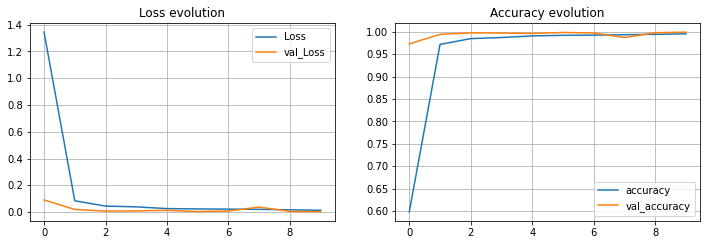

In [49]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

# Model 3

Text(0.5, 1.0, 'Accuracy evolution')

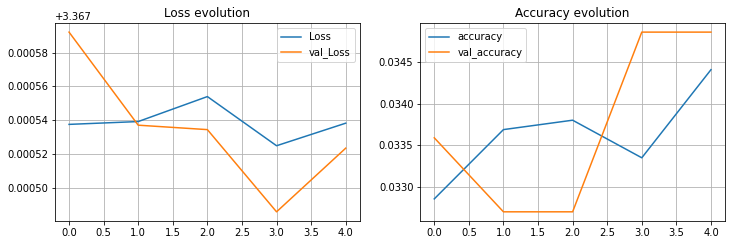

In [54]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history3.history['loss'], label='Loss')
plt.plot(history3.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

### Model 2 is the superior one hence model 2 will be selected

In [28]:
mlp2.save('Alphabet Classifier')

INFO:tensorflow:Assets written to: Alphabet Classifier\assets


# Testing And Evaluation

In [41]:
test_loss, test_acc = mlp2.evaluate(X_test, y_test)

272/272 [==============================] - 4s 14ms/step - loss: 0.0051 - accuracy: 0.9982


In [34]:
pred = mlp2.predict(X_test)

In [35]:
import itertools

In [38]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes_alphabet))
    plt.xticks(tick_marks, classes_alphabet, rotation=45)
    plt.yticks(tick_marks, classes_alphabet)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()


<Figure size 1440x1440 with 0 Axes>

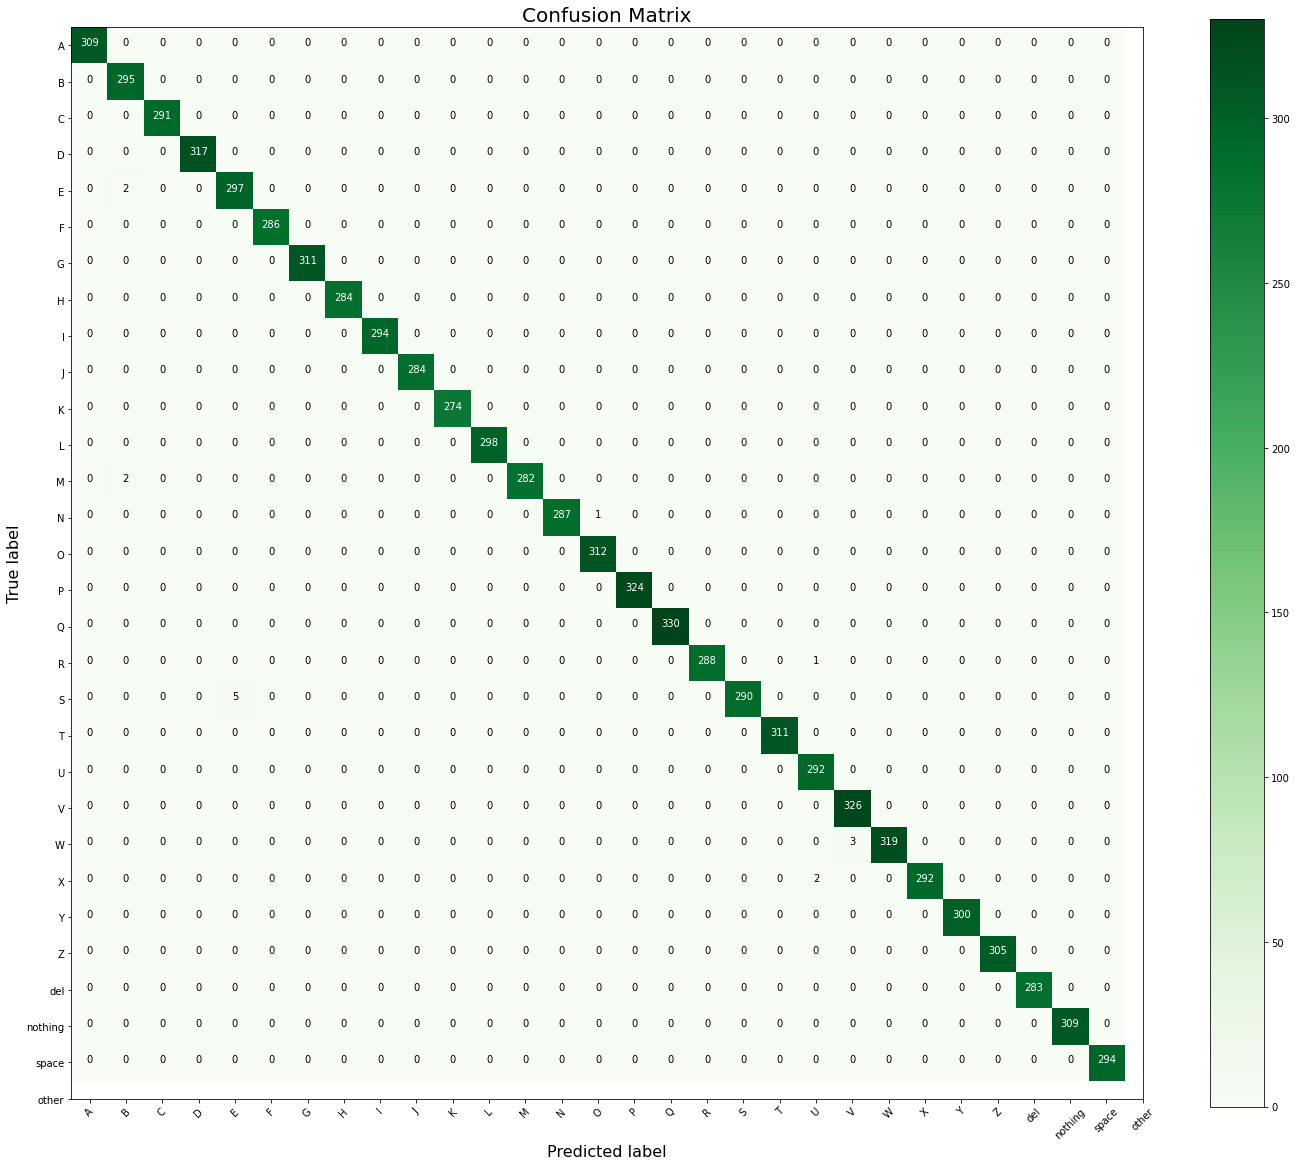

In [39]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, pred)
plt.show()

# Convert Model into TFLite

In [42]:
converter = tf.lite.TFLiteConverter.from_saved_model('Alphabet Classifier')
tflite_model = converter.convert()

with open('Alphabet_Classifier_Lite.tflite', 'wb') as f:
  f.write(tflite_model)
